# Pixel Size Analysis at Different Distances

This notebook analyzes pixel sizes of Gaussian splats at different camera distances. It loads data from distance culling experiments and creates histograms to visualize how pixel sizes vary with distance to the bounding box center.

## Features:
- Loads data from multiple formats (NPZ files, text files)
- Automatically finds closest, medium, and farthest distance measurements
- Creates side-by-side histograms with statistics
- Shows culling threshold (2.0 pixel size) for analysis


In [176]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

# Set up matplotlib for better plots
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10

%matplotlib inline


## Data Loading Functions

These functions handle loading data from different file formats generated by the distance culling functions.


In [177]:
def load_npz_data(npz_file: str):
    """Load data from a single NPZ file."""
    data = np.load(npz_file)
    return {
        "pixel_sizes": data["pixel_sizes"],
        "distance_to_bbox_center": data["distance_to_bbox_center"],
        "camera_position": data.get("camera_position", None),
        "bbox_center": data.get("bbox_center", None),
        "num_gaussians": data["num_gaussians"],
        "rendered_gaussians": data["rendered_gaussians"],
    }


def load_multiple_npz_files(pattern: str):
    """Load data from multiple timestamped NPZ files."""
    files = sorted(glob.glob(pattern))
    all_data = []

    for file in files:
        try:
            data = load_npz_data(file)
            data["filename"] = file
            all_data.append(data)
        except Exception as e:
            print(f"Error loading {file}: {e}")

    return all_data

In [178]:
def load_append_data(txt_file: str):
    """Load data from fast-append text file."""
    all_data = []

    try:
        with open(txt_file, "r") as f:
            for line_num, line in enumerate(f):
                try:
                    parts = line.strip().split(",")
                    timestamp = float(parts[0])
                    distance_to_bbox = float(parts[1])
                    num_gaussians = int(parts[2])
                    pixel_sizes = np.array([float(x) for x in parts[3:]])

                    all_data.append(
                        {
                            "pixel_sizes": pixel_sizes,
                            "distance_to_bbox_center": distance_to_bbox,
                            "num_gaussians": num_gaussians,
                            "timestamp": timestamp,
                            "line_num": line_num,
                        }
                    )
                except Exception as e:
                    print(f"Error parsing line {line_num}: {e}")

    except Exception as e:
        print(f"Error reading {txt_file}: {e}")

    return all_data

## Analysis Functions

Functions to find the closest, medium, and farthest distance measurements from the loaded data.


In [179]:
def find_closest_medium_farthest(all_data: list):
    """Find the closest, medium, and farthest distance measurements."""
    if len(all_data) == 0:
        return None, None, None

    # First, handle duplicate distances by keeping only the one with highest num_gaussians
    # Group by distance_to_bbox_center
    distance_groups = {}
    for data in all_data:
        distance = data["distance_to_bbox_center"]
        dist_key = f"{distance:.3f}"
        if dist_key not in distance_groups:
            distance_groups[dist_key] = []
        distance_groups[dist_key].append(data)

    # For each distance group, keep only the data point with highest num_gaussians
    # If a distance group has only one data point, we remove it. Probably, spurious data during zoom in or zoom out.
    filtered_data = []
    print("Filtered data:")
    for distance, group in distance_groups.items():
        if len(group) == 1:
            continue
        else:
            # Keep the one with highest rendered_gaussians
            best_data = max(group, key=lambda x: x["rendered_gaussians"])
            filtered_data.append(best_data)
        print(
            f"Distance: {distance}, Total Gaussians: {filtered_data[-1]['num_gaussians']}, Rendered Gaussians: {filtered_data[-1]['rendered_gaussians']}"
        )

    # Now work with filtered data
    if len(filtered_data) == 0:
        return None, None, None

    # Extract distances from filtered data
    distances = [d["distance_to_bbox_center"] for d in filtered_data]

    if len(filtered_data) == 1:
        return filtered_data[0], None, None
    elif len(filtered_data) == 2:
        if distances[0] < distances[1]:
            return filtered_data[0], None, filtered_data[1]
        else:
            return filtered_data[1], None, filtered_data[0]
    else:
        # Find indices for min, max, and median distance
        min_idx = np.argmin(distances)
        max_idx = np.argmax(distances)

        # For medium, find the distance closest to median
        median_distance = np.median(distances)
        medium_idx = np.argmin(np.abs(np.array(distances) - median_distance))

        # Make sure medium is different from min and max
        if medium_idx == min_idx or medium_idx == max_idx:
            # Find the index with distance closest to median but not min/max
            sorted_indices = np.argsort(distances)
            medium_idx = sorted_indices[len(sorted_indices) // 2]

        return filtered_data[min_idx], filtered_data[medium_idx], filtered_data[max_idx]

## Plotting Functions

Create histograms showing pixel size distributions at different distances.


In [180]:
def plot_three_distance_histograms(
    closest_data, medium_data, farthest_data, output_dir: str = "plots"
):
    """Plot histograms for closest, medium, and farthest distances."""

    # Collect valid data
    data_list = []
    labels = []
    colors = ["blue", "orange", "red"]

    if closest_data is not None:
        data_list.append(closest_data)
        labels.append(f"Closest\n({closest_data['distance_to_bbox_center']:.2f}m)")

    if medium_data is not None:
        data_list.append(medium_data)
        labels.append(f"Medium\n({medium_data['distance_to_bbox_center']:.2f}m)")

    if farthest_data is not None:
        data_list.append(farthest_data)
        labels.append(f"Farthest\n({farthest_data['distance_to_bbox_center']:.2f}m)")

    if len(data_list) == 0:
        print("No data to plot!")
        return

    # Create subplots
    fig, axes = plt.subplots(1, len(data_list), figsize=(5 * len(data_list), 5))
    if len(data_list) == 1:
        axes = [axes]  # Make it iterable

    fig.suptitle("Pixel Size Histograms at Different Distances", fontsize=14)

    for i, (data, label) in enumerate(zip(data_list, labels)):
        pixel_sizes = data["pixel_sizes"]
        color = colors[i]

        # Plot histogram
        axes[i].hist(pixel_sizes, bins=50, alpha=0.7, color=color, edgecolor="black")
        axes[i].axvline(
            x=2.0,
            color="red",
            linestyle="--",
            linewidth=2,
            label="Culling Threshold (2.0)",
        )
        axes[i].set_title(label, fontsize=12)
        axes[i].set_xlabel("Pixel Size")
        axes[i].set_ylabel("Count")
        axes[i].grid(True, alpha=0.3)
        axes[i].legend()

        # Add statistics text
        total = len(pixel_sizes)
        passing = np.sum(pixel_sizes >= 2.0)
        mean_size = np.mean(pixel_sizes)
        culled = total - passing

        stats_text = f"Total: {total}\nCulled: {culled} ({100.0*culled/total:.1f}%)\nMean pixel size: {mean_size:.3f}"
        axes[i].text(
            0.02,
            0.98,
            stats_text,
            transform=axes[i].transAxes,
            verticalalignment="top",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
            fontsize=9,
        )

    plt.tight_layout()

    # Save plot
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(
        f"{output_dir}/pixel_size_histograms_three_distances.png",
        dpi=300,
        bbox_inches="tight",
    )
    plt.show()

    # Print summary
    print("\n=== Summary ===")
    for i, (data, label) in enumerate(zip(data_list, labels)):
        pixel_sizes = data["pixel_sizes"]
        total = len(pixel_sizes)
        passing = np.sum(pixel_sizes >= 2.0)
        mean_size = np.mean(pixel_sizes)
        std_size = np.std(pixel_sizes)

        distance_label = label.split("\n")[0]  # Remove distance from label
        print(
            f"{distance_label}: Distance={data['distance_to_bbox_center']:.3f}m, "
            f"Mean={mean_size:.3f}, Std={std_size:.3f}, "
            f"Passing={passing}/{total} ({100*passing/total:.1f}%)"
        )

In [181]:
def analyze_data(data_source: str, output_dir: str = "plots"):
    """Main analysis function that handles both NPZ and TXT formats."""

    if data_source.endswith(".txt"):
        # Fast-append text format
        print(f"Loading fast-append data from: {data_source}")
        all_data = load_append_data(data_source)

    elif "*" in data_source or data_source.endswith(".npz"):
        # NPZ format (single or multiple files)
        if "*" in data_source:
            print(f"Loading multiple NPZ files: {data_source}")
            all_data = load_multiple_npz_files(data_source)
        else:
            print(f"Loading single NPZ file: {data_source}")
            all_data = [load_npz_data(data_source)]
    else:
        print(f"Unknown file format: {data_source}")
        return

    if not all_data:
        print("No data found!")
        return

    print(f"Loaded {len(all_data)} measurement(s)")

    # Find closest, medium, and farthest distances
    closest_data, medium_data, farthest_data = find_closest_medium_farthest(all_data)

    # Plot the three histograms
    plot_three_distance_histograms(closest_data, medium_data, farthest_data, output_dir)

    return closest_data, medium_data, farthest_data

## Usage Examples

### Supported Data Formats:
- **Single NPZ file**: `pixel_sizes_vs_distance.npz`
- **Multiple timestamped NPZ files**: `pixel_sizes_vs_distance_*.npz`
- **Fast-append text file**: `pixel_sizes_data.txt`

### Example Usage:


Found timestamped NPZ files, analyzing...
Loading multiple NPZ files: /main/rajrup/Dropbox/Project/GsplatStream/gsplat/results/actorshq_l1_0.5_ssim_0.5_alpha_1.0/Actor01/Sequence1/resolution_4/0/distance_culling//pixel_sizes_vs_distance_*.npz
Loaded 22 measurement(s)
Filtered data:
Distance: 2.297, Total Gaussians: 347067, Rendered Gaussians: 12678
Distance: 2.029, Total Gaussians: 347067, Rendered Gaussians: 14981
Distance: 1.378, Total Gaussians: 347067, Rendered Gaussians: 23459
Distance: 0.937, Total Gaussians: 347067, Rendered Gaussians: 34584
Distance: 0.680, Total Gaussians: 347067, Rendered Gaussians: 46577
Distance: 0.367, Total Gaussians: 277735, Rendered Gaussians: 58549


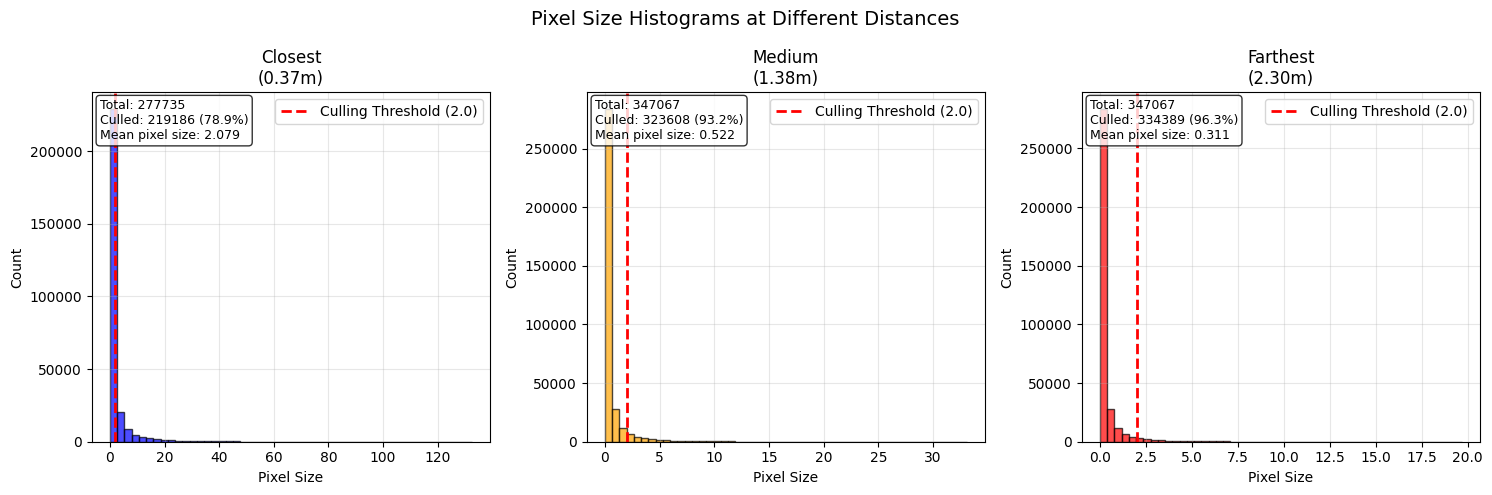


=== Summary ===
Closest: Distance=0.367m, Mean=2.079, Std=5.949, Passing=58549/277735 (21.1%)
Medium: Distance=1.378m, Mean=0.522, Std=1.441, Passing=23459/347067 (6.8%)
Farthest: Distance=2.297m, Mean=0.311, Std=0.860, Passing=12678/347067 (3.7%)


In [182]:
# Example 1: Auto-detect and analyze available data files
# This will automatically find and analyze data files in the current directory

actor_id = "Actor01"
sequence_id = "Sequence1"
resolution = 4
frame_id = 0

exp_name = "actorshq_l1_0.5_ssim_0.5_alpha_1.0"

distance_culling_dir = f"/main/rajrup/Dropbox/Project/GsplatStream/gsplat/results/{exp_name}/{actor_id}/{sequence_id}/resolution_{resolution}/{frame_id}/distance_culling/"

if os.path.exists(f"{distance_culling_dir}/pixel_sizes_data.txt"):
    print("Found fast-append data, analyzing...")
    results = analyze_data(f"{distance_culling_dir}/pixel_sizes_data.txt")
elif os.path.exists(f"{distance_culling_dir}/pixel_sizes_vs_distance.npz"):
    print("Found NPZ data, analyzing...")
    results = analyze_data(f"{distance_culling_dir}/pixel_sizes_vs_distance.npz")
elif glob.glob(f"{distance_culling_dir}/pixel_sizes_vs_distance_*.npz"):
    print("Found timestamped NPZ files, analyzing...")
    results = analyze_data(f"{distance_culling_dir}/pixel_sizes_vs_distance_*.npz")
else:
    print("No data files found. Run distance_culling() first.")
    print("Supported formats:")
    print("  - pixel_sizes_data.txt (fast-append)")
    print("  - pixel_sizes_vs_distance.npz (single NPZ)")
    print("  - pixel_sizes_vs_distance_*.npz (multiple NPZ)")

In [183]:
# Example 2: Analyze specific files manually
# Uncomment and modify the lines below to analyze specific files

# For fast-append text file:
# results = analyze_data("pixel_sizes_data.txt")

# For single NPZ file:
# results = analyze_data("pixel_sizes_vs_distance.npz")

# For multiple timestamped NPZ files:
# results = analyze_data("pixel_sizes_vs_distance_*.npz")

# For files in a specific directory:
# results = analyze_data("../data/pixel_sizes_data.txt")

In [184]:
# Example 3: Access individual results for further analysis
# After running analyze_data(), you can access the individual datasets

# Uncomment after running analyze_data() above:
# closest_data, medium_data, farthest_data = results

# if closest_data:
#     print(f"Closest distance: {closest_data['distance_to_bbox_center']:.3f}m")
#     print(f"Number of Gaussians: {closest_data['num_gaussians']}")
#     print(f"Pixel sizes shape: {closest_data['pixel_sizes'].shape}")
#     print(f"Mean pixel size: {np.mean(closest_data['pixel_sizes']):.3f}")

# # You can also create custom plots or analysis
# if closest_data and farthest_data:
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
#
#     ax1.hist(closest_data['pixel_sizes'], bins=30, alpha=0.7, color='blue', label='Closest')
#     ax1.hist(farthest_data['pixel_sizes'], bins=30, alpha=0.7, color='red', label='Farthest')
#     ax1.set_xlabel('Pixel Size')
#     ax1.set_ylabel('Count')
#     ax1.set_title('Comparison: Closest vs Farthest')
#     ax1.legend()
#     ax1.grid(True, alpha=0.3)
#
#     # Box plot comparison
#     data_to_plot = [closest_data['pixel_sizes'], farthest_data['pixel_sizes']]
#     ax2.boxplot(data_to_plot, labels=['Closest', 'Farthest'])
#     ax2.set_ylabel('Pixel Size')
#     ax2.set_title('Box Plot Comparison')
#     ax2.grid(True, alpha=0.3)
#
#     plt.tight_layout()
#     plt.show()